# Unsupervised Capstone: Movie recommendation system
----------------------------------------------

![alt text][logo]

[logo]: https://www.vshsolutions.com/wp-content/uploads/2020/02/recommender-system-for-movie-recommendation.jpg 

## Context:

Recommendation system has long become an essential part of any business and e-commerce. It plays an important role in not only supporting customers making optimal decisions, but also improving business operations.

Whether you want to introduce people among themselves in your social network, try to recommend a similarly purchased item to the customers or need a hint for yourself which movie to watch in the evening, there are unlimited possibilities to apply recommendation engines/systems around us.

In this notebook we will explore and compare different algorithms and approaches to movies recommendation.

This dataset(including multiple files) was downloaded from [Kaggle](https://www.kaggle.com/rounakbanik/the-movies-dataset), and it contains metadata for all 45,000 movies. The dataset consists of movies released on or before July 2017. Data points include cast, crew, plot keywords, budget, revenue, posters, release dates, languages, production companies, countries, TMDB vote counts and vote averages.

## Content:

This dataset has files containing 26 million ratings from 270,000 users for all 45,000 movies. Ratings are on a scale of 1-5 and have been obtained from the official GroupLens website.

The files included are:

* **movies_metadata.csv**: The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.

* **keywords.csv**: Contains the movie plot keywords for our MovieLens movies. Available in the form of a stringified JSON Object.

* **credits.csv**: Consists of Cast and Crew Information for all our movies. Available in the form of a stringified JSON Object.

* **links.csv**: The file that contains the TMDB and IMDB IDs of all the movies featured in the Full MovieLens dataset.

* **links_small.csv**: Contains the TMDB and IMDB IDs of a small subset of 9,000 movies of the Full Dataset.

* **ratings_small.csv**: The subset of 100,000 ratings from 700 users on 9,000 movies.

## Kernel directory:

I. Import libraries and load the dataset:  
    * Data cleaning 
    * Data imputation
    * Feature extraction

II. Exploratory Data Analysis:
    * Numerical feature analysis
    * Categorical & text feature analysis
    * Feature transformation

III. Build recommendation system:
    * Popularity-based recommender using weighted rating
    * Content-based recommender using cosine similarity
    * Content-based recommender using DBSCAN and Kmeans
    * Collaborative filtering using Pearson correlation
    * Collaborative filtering using K-nearest neighbor
    
IV. Conclusion:
    
----------------------------------------------------------------

### I. Import libraries and load the dataset:
####  Import libraries:

In [1]:
# Import libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from ast import literal_eval

import nltk
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity


# Pandas display preferences
%matplotlib inline
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Plotly visualization
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
py.init_notebook_mode(connected = True) # Required to use plotly offline in jupyter notebook

import cufflinks as cf #importing plotly and cufflinks in offline mode  
import plotly.offline  
cf.go_offline()  
cf.set_config_file(offline=False, world_readable=True)

import plotly.io as pio # To render offline visualizations
pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook_connected'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery']

####  Load the dataset:

In [2]:
# Load the movie_metadata dataset
df1 = pd.read_csv('movies_metadata.csv')

# Inspect the dataset by printing out the first 5 rows of the df1:
df1.head()

adult                              belongs_to_collection    budget                                             genres                              homepage     id    imdb_id original_language               original_title                                           overview popularity                       poster_path                               production_companies                               production_countries release_date       revenue  runtime                                   spoken_languages    status                                            tagline                        title  video  vote_average  vote_count
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...  http://toystory.disney.com/toy-story    862  tt0114709                en                    Toy Story  Led by Woody, Andy's toys live happily in his ...     21.947  /rhIRbceoE9lR4veEXuwCC2wARtG.jpg     [{'name': 'Pixar Animation Studios', 'id': 3}]  [{'iso_3166_1': 'US', 'name': 'United States o...   1995-10-30 373554033.000   81.000           [{'iso_639_1': 'en', 'name': 'English'}]  Released                                                NaN                    Toy Story  False         7.700    5415.000
1  False                                                NaN  65000000  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...                                   NaN   8844  tt0113497                en                      Jumanji  When siblings Judy and Peter discover an encha...     17.016  /vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg  [{'name': 'TriStar Pictures', 'id': 559}, {'na...  [{'iso_3166_1': 'US', 'name': 'United States o...   1995-12-15 262797249.000  104.000  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...  Released          Roll the dice and unleash the excitement!                      Jumanji  False         6.900    2413.000
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...                                   NaN  15602  tt0113228                en             Grumpier Old Men  A family wedding reignites the ancient feud be...     11.713  /6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg  [{'name': 'Warner Bros.', 'id': 6194}, {'name'...  [{'iso_3166_1': 'US', 'name': 'United States o...   1995-12-22         0.000  101.000           [{'iso_639_1': 'en', 'name': 'English'}]  Released  Still Yelling. Still Fighting. Still Ready for...             Grumpier Old Men  False         6.500      92.000
3  False                                                NaN  16000000  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...                                   NaN  31357  tt0114885                en            Waiting to Exhale  Cheated on, mistreated and stepped on, the wom...      3.859  /16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg  [{'name': 'Twentieth Century Fox Film Corporat...  [{'iso_3166_1': 'US', 'name': 'United States o...   1995-12-22  81452156.000  127.000           [{'iso_639_1': 'en', 'name': 'English'}]  Released  Friends are the people who let you be yourself...            Waiting to Exhale  False         6.100      34.000
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0                     [{'id': 35, 'name': 'Comedy'}]                                   NaN  11862  tt0113041                en  Father of the Bride Part II  Just when George Banks has recovered from his ...      8.388  /e64sOI48hQXyru7naBFyssKFxVd.jpg  [{'name': 'Sandollar Productions', 'id': 5842}...  [{'iso_3166_1': 'US', 'name': 'United States o...   1995-02-10  76578911.000  106.000           [{'iso_639_1': 'en', 'name': 'English'}]  Released  Just When His World Is Back To Normal... He's ...  Father of the Bride Part II  False         5.700     173.000

Just from looking at the first 5 rows of the movies_metadata dataset, we can see that there's cleaning work that needs to be done, as well as feature extraction to extract information from features that contain dictionaries.

####  Data cleaning:

In [3]:
# Drop columns that won't be used for our analysis:
df1 = df1.drop(['belongs_to_collection', 'budget', 'homepage', 'imdb_id', 'poster_path', 'production_countries', 'title', 'video', 'adult'], axis=1)

# Feature extractions:
df1['genres'] = df1['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df1['production_companies'] = df1['production_companies'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df1['spoken_languages'] = df1['spoken_languages'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df1['year'] = pd.to_datetime(df1['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

# Drop 'release_date' column after extracting the year field:
df1 = df1.drop('release_date', axis=1)

In [4]:
# Inspect column datatypes. There are 17 features in the first dataset:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 15 columns):
genres                  45466 non-null object
id                      45466 non-null object
original_language       45455 non-null object
original_title          45466 non-null object
overview                44512 non-null object
popularity              45461 non-null object
production_companies    45466 non-null object
revenue                 45460 non-null float64
runtime                 45203 non-null float64
spoken_languages        45466 non-null object
status                  45379 non-null object
tagline                 20412 non-null object
vote_average            45460 non-null float64
vote_count              45460 non-null float64
year                    45466 non-null object
dtypes: float64(4), object(11)
memory usage: 5.2+ MB


In [5]:
# There are 'NaT' values in 'year' column that are not missing values. We'll drop rows with year = 'NaT' 
# to make sure there's only numeric values for year feature:
year_indices = df1[df1['year'] == 'NaT'].index # get indices of rows with year value = 'NaT'
df1 = df1.drop(index = year_indices) # drop rows with listed indices

# Convert year to integer:
df1['year'] = df1['year'].astype('int64')

# Inspect missing values:
missing_values = df1.isnull().sum()/len(df1)
missing_values[missing_values>0] # Show any feature with any missing values

original_language   0.000
overview            0.021
runtime             0.005
status              0.002
tagline             0.550
dtype: float64

Above are features that contain missing values. There are 5 features total. As we can see, tagline and overview are the 2 columns with the most missing values. We'll fill missing values for these 2 variables with 'unknown' indicating there's no available tagline and overview for the associated movies. 

For other features, since the number of missing values is minimal, we'll go ahead and drop them.

#### Data imputation:

In [6]:
# Fill na with 'unknown' for overview and tagline to indicate no available data:
cols = ['overview', 'tagline']
for col in cols:
    df1[col] = df1[col].fillna('unknown', axis=0)

# Drop missing values accross columns:
df1 = df1.dropna(axis=0)

# Convert 'id' to int64:
df1['id'] = df1['id'].astype('int64')

In [7]:
# Double check to make sure there's no more missing data:
missing_values = df1.isnull().sum()/len(df1)
missing_values[missing_values>0]

Series([], dtype: float64)

#### Load the second dataset:

In [8]:
# Load the 'credits' dataset to extract cast and crew members:
df2 = pd.read_csv('credits.csv')

# Print out the first 5 rows of df2:
df2.head()

cast                                               crew     id
0  [{'cast_id': 14, 'character': 'Woody (voice)',...  [{'credit_id': '52fe4284c3a36847f8024f49', 'de...    862
1  [{'cast_id': 1, 'character': 'Alan Parrish', '...  [{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...   8844
2  [{'cast_id': 2, 'character': 'Max Goldman', 'c...  [{'credit_id': '52fe466a9251416c75077a89', 'de...  15602
3  [{'cast_id': 1, 'character': "Savannah 'Vannah...  [{'credit_id': '52fe44779251416c91011acb', 'de...  31357
4  [{'cast_id': 1, 'character': 'George Banks', '...  [{'credit_id': '52fe44959251416c75039ed7', 'de...  11862

In [9]:
# Inspect column datatype and missing values. It looks like there's no missing values in the second dataset.
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
cast    45476 non-null object
crew    45476 non-null object
id      45476 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [10]:
# Feature extractions:
df2['cast'] = df2['cast'].fillna('').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df2['director'] = df2['crew'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df2 = df2.drop('crew', axis=1)

It looks like the second dataset doesn't contain any missing values. After performing some feature extraction to extract the cast and the directors for each movie, we'll merge the 2 datasets together to create the master dataset for analysis.

#### Merge the 2 datasets:

In [11]:
# Merge 2 dataset together:
df = df1.merge(df2, how='inner', on='id') 

# Print out the first 5 rows of the master dataset:
df.head()

genres     id original_language               original_title                                           overview popularity                               production_companies       revenue  runtime     spoken_languages    status                                            tagline  vote_average  vote_count  year                                               cast                                           director
0   [Animation, Comedy, Family]    862                en                    Toy Story  Led by Woody, Andy's toys live happily in his ...     21.947                          [Pixar Animation Studios] 373554033.000   81.000            [English]  Released                                            unknown         7.700    5415.000  1995  [Tom Hanks, Tim Allen, Don Rickles, Jim Varney...  [John Lasseter, Joss Whedon, Andrew Stanton, J...
1  [Adventure, Fantasy, Family]   8844                en                      Jumanji  When siblings Judy and Peter discover an encha...     17.016  [TriStar Pictures, Teitler Film, Interscope Co... 262797249.000  104.000  [English, Français]  Released          Roll the dice and unleash the excitement!         6.900    2413.000  1995  [Robin Williams, Jonathan Hyde, Kirsten Dunst,...  [Larry J. Franco, Jonathan Hensleigh, James Ho...
2             [Romance, Comedy]  15602                en             Grumpier Old Men  A family wedding reignites the ancient feud be...     11.713                     [Warner Bros., Lancaster Gate]         0.000  101.000            [English]  Released  Still Yelling. Still Fighting. Still Ready for...         6.500      92.000  1995  [Walter Matthau, Jack Lemmon, Ann-Margret, Sop...  [Howard Deutch, Mark Steven Johnson, Mark Stev...
3      [Comedy, Drama, Romance]  31357                en            Waiting to Exhale  Cheated on, mistreated and stepped on, the wom...      3.859           [Twentieth Century Fox Film Corporation]  81452156.000  127.000            [English]  Released  Friends are the people who let you be yourself...         6.100      34.000  1995  [Whitney Houston, Angela Bassett, Loretta Devi...  [Forest Whitaker, Ronald Bass, Ronald Bass, Ez...
4                      [Comedy]  11862                en  Father of the Bride Part II  Just when George Banks has recovered from his ...      8.388       [Sandollar Productions, Touchstone Pictures]  76578911.000  106.000            [English]  Released  Just When His World Is Back To Normal... He's ...         5.700     173.000  1995  [Steve Martin, Diane Keaton, Martin Short, Kim...  [Alan Silvestri, Elliot Davis, Nancy Meyers, N...

In [12]:
# Create a stacked dataframe for later use in building content-based recommender: 
s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
genres_df = df.drop('genres', axis=1).join(s)

In [13]:
# Create function to convert list to string to ensure data structure cosistency:
def list_to_string(l):
    try:
        return ', '.join(map(str, l))
    except TypeError:
        return 'unknown'

# Apply function to features:
cols = ['genres', 'production_companies', 'spoken_languages', 'cast', 'director']    
for col in cols:
     df[col] = df[col].apply(list_to_string)
        
# Print out the final master dataset after applying function:
df.head()

genres     id original_language               original_title                                           overview popularity                               production_companies       revenue  runtime   spoken_languages    status                                            tagline  vote_average  vote_count  year                                               cast                                           director
0   Animation, Comedy, Family    862                en                    Toy Story  Led by Woody, Andy's toys live happily in his ...     21.947                            Pixar Animation Studios 373554033.000   81.000            English  Released                                            unknown         7.700    5415.000  1995  Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...  John Lasseter, Joss Whedon, Andrew Stanton, Jo...
1  Adventure, Fantasy, Family   8844                en                      Jumanji  When siblings Judy and Peter discover an encha...     17.016  TriStar Pictures, Teitler Film, Interscope Com... 262797249.000  104.000  English, Français  Released          Roll the dice and unleash the excitement!         6.900    2413.000  1995  Robin Williams, Jonathan Hyde, Kirsten Dunst, ...  Larry J. Franco, Jonathan Hensleigh, James Hor...
2             Romance, Comedy  15602                en             Grumpier Old Men  A family wedding reignites the ancient feud be...     11.713                       Warner Bros., Lancaster Gate         0.000  101.000            English  Released  Still Yelling. Still Fighting. Still Ready for...         6.500      92.000  1995  Walter Matthau, Jack Lemmon, Ann-Margret, Soph...  Howard Deutch, Mark Steven Johnson, Mark Steve...
3      Comedy, Drama, Romance  31357                en            Waiting to Exhale  Cheated on, mistreated and stepped on, the wom...      3.859             Twentieth Century Fox Film Corporation  81452156.000  127.000            English  Released  Friends are the people who let you be yourself...         6.100      34.000  1995  Whitney Houston, Angela Bassett, Loretta Devin...  Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...
4                      Comedy  11862                en  Father of the Bride Part II  Just when George Banks has recovered from his ...      8.388         Sandollar Productions, Touchstone Pictures  76578911.000  106.000            English  Released  Just When His World Is Back To Normal... He's ...         5.700     173.000  1995  Steve Martin, Diane Keaton, Martin Short, Kimb...  Alan Silvestri, Elliot Davis, Nancy Meyers, Na...

In [14]:
# Print out the shape of master movie data:
df.shape

(45118, 17)

### II. Exploratory Data Analysis:

In [15]:
# Print out statistics for numeric variables:
df.describe()

id        revenue   runtime  vote_average  vote_count      year
count  45118.000      45118.000 45118.000     45118.000   45118.000 45118.000
mean  107177.798   11302019.987    94.232         5.638     110.779  1991.845
std   111579.197   64569612.552    38.298         1.897     493.076    24.079
min        2.000          0.000     0.000         0.000       0.000  1874.000
25%    26195.750          0.000    85.000         5.000       3.000  1978.000
50%    59244.500          0.000    95.000         6.000      10.000  2001.000
75%   153737.750          0.000   107.000         6.800      35.000  2010.000
max   469172.000 2787965087.000  1256.000        10.000   14075.000  2020.000

In [16]:
# Print out statistics for categorial/text variable:
df.describe(include ='object')

genres original_language original_title overview popularity production_companies spoken_languages    status  tagline   cast director
count   45118             45118          45118    45118      45118                45118            45118     45118    45118  45118    45118
unique   4057                89          42969    44160      43857                22596             1837         6    20258  42382    42661
top     Drama                en       Blackout  unknown      1e-06                               English  Released  unknown                
freq     4968             32177             12      682         28                11586            22382     44759    24706   2298      674

Looking through the statistics for the movie dataset, there's a few things that stand out immediately:
   * The variance in revenue featue is very large, with the min value of 0 and max value of billions of dollars. This, with a high standard deviation, indicating that there are some outliners in our dataset.
   * It looks like vote average range from 0-10 for each movies. The movie with the most vote count has over 14000 counts, while there are movies with no vote at all.
   * The oldest movie was made in 1874, and the newest in 2020.
   * The majority of movies are English spoken with English as the original language.
   * Only less than half of the movies included have any tagline.
   
After inspecting the dataset based on preliminary statistics, let's visualize some features to have a better understanding of the dataset.

#### What's movie revenue distribution? What's the relation between revenue and votes?

In [17]:
# Restrict revenue >0 and <1.5B to prevent outliners:
df = df[df['revenue']>0]
df = df[df['revenue']<1500000000.000]
revenue = df['revenue'].tolist()

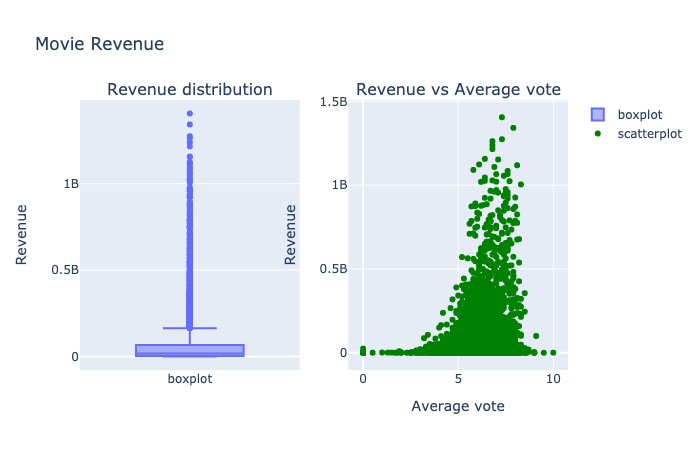

In [18]:
# Create subplots:
fig = make_subplots(rows=1, cols=2, 
                    subplot_titles=("Revenue distribution", "Revenue vs Average vote"))

# Add traces for the 2 subplots
fig.add_trace(
    go.Box(y=revenue, name='boxplot'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=df['vote_average'], 
               y=df['revenue'], 
               mode='markers', 
               marker_color='green', 
               name='scatterplot'),
    row=1, col=2
)

# Update x-axis and y-axis labels:
fig.update_xaxes(title_text="Average vote", row=1, col=2)
fig.update_yaxes(title_text="Revenue", row=1, col=1)
fig.update_yaxes(title_text="Revenue", row=1, col=2)

fig.update_layout(height=600, width=900, title_text="Movie Revenue")

# iplot(fig) # for Jupiter notebook use

fig.show("png") # show static visualization for Github use

The 2 charts above show the distribution of movie revenue and the relationship between revenue and average_vote for each movie. Just looking at the first chart, we can see that our revenue data is very skewed, with a high variance between movies with the higest revenue and movies with the lowest revenue. 

Between revenue and average vote, there's a trend where the higher the average vote a movie has, the more revenue it earns. Howver, this relationship is not strong.


#### What's the distribution of movies by year?

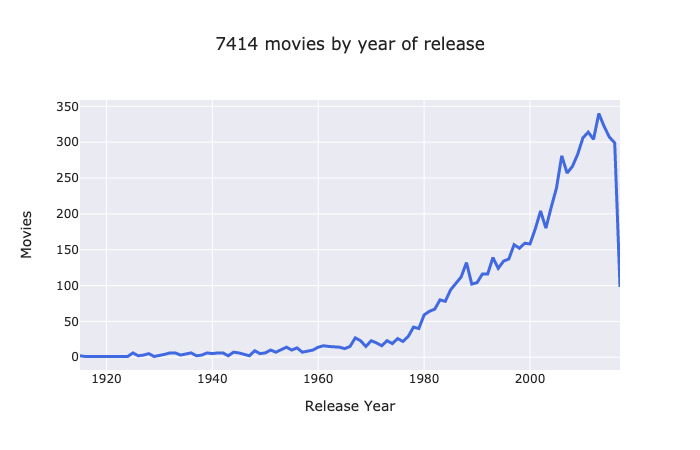

In [19]:
# Get data
data = df['year'].value_counts().sort_index()

# Create trace
trace = go.Scatter(x = data.index,
                   y = data.values,
                   line=dict(color='royalblue', width=3))
# Create layout
layout = go.Layout(template='seaborn', 
                   title = '{} movies by year of release'.format(df.shape[0]),
                   xaxis = dict(title = 'Release Year'),
                   yaxis = dict(title = 'Movies'))

# Create plot
fig = go.Figure(data=[trace], layout=layout)

# iplot(fig)
fig.show("png")

#### In what language was movies produced?

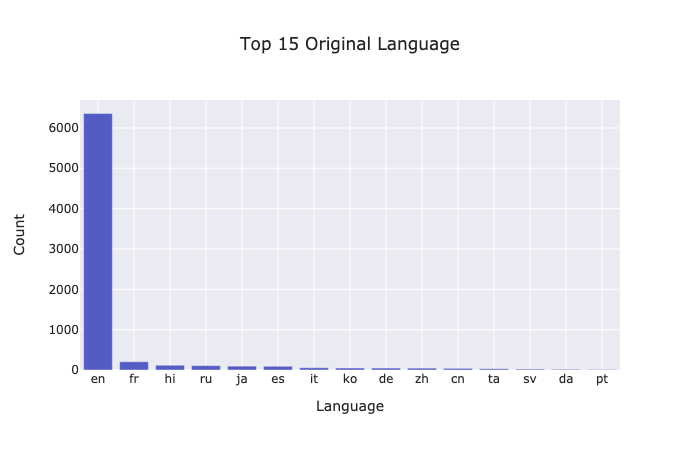

In [20]:
# Get data:
top_languages = df['original_language'].value_counts().reset_index()[:15]

# Create trace
trace = go.Bar(x = top_languages['index'], 
               y = top_languages['original_language'], 
               marker = dict(color = 'rgb(84, 92, 196)', 
                             ))

layout = go.Layout(template= "seaborn",title = 'Top 15 Original Language' , xaxis = dict(title = 'Language'), yaxis = dict(title = 'Count'))

fig = go.Figure(data = [trace], layout = layout)

# fig.show()
fig.show("png")

English accounts for the most movie language, followed by french. However, the majority of movies are in has English as original language.

#### What's the relationship between vote_count, vote_average, and popularity?

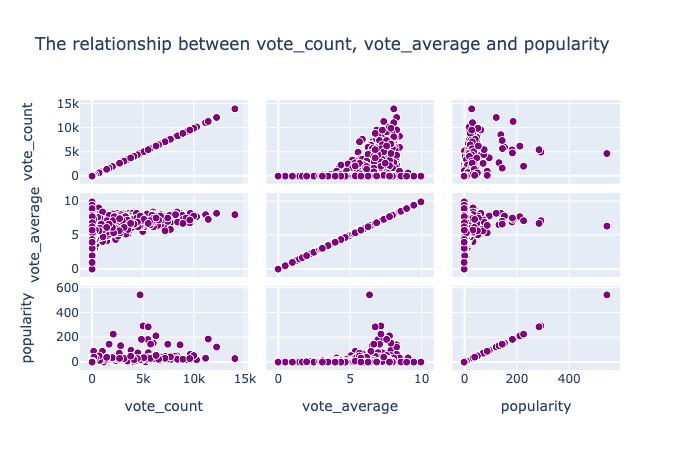

In [21]:
fig = go.Figure(data=go.Splom(
                dimensions=[dict(label='vote_count', values=df['vote_count']),
                            dict(label='vote_average', values=df['vote_average']),
                            dict(label='popularity',values=df['popularity'])
                           ],
                marker=dict(line_color='white', line_width=0.5), 
                marker_color='purple'
                ))


fig.update_layout(
    title='The relationship between vote_count, vote_average and popularity',
    dragmode='select',
    width=800,
    height=700,
    hovermode='closest',
)

# iplot(fig)
fig.show("png")

In [22]:
# Let's use the stacked dataframe that we created earlier:
genres_df.head()

id original_language original_title                                           overview popularity                               production_companies       revenue  runtime     spoken_languages    status                                    tagline  vote_average  vote_count  year                                               cast                                           director      genre
0   862                en      Toy Story  Led by Woody, Andy's toys live happily in his ...     21.947                          [Pixar Animation Studios] 373554033.000   81.000            [English]  Released                                    unknown         7.700    5415.000  1995  [Tom Hanks, Tim Allen, Don Rickles, Jim Varney...  [John Lasseter, Joss Whedon, Andrew Stanton, J...  Animation
0   862                en      Toy Story  Led by Woody, Andy's toys live happily in his ...     21.947                          [Pixar Animation Studios] 373554033.000   81.000            [English]  Released                                    unknown         7.700    5415.000  1995  [Tom Hanks, Tim Allen, Don Rickles, Jim Varney...  [John Lasseter, Joss Whedon, Andrew Stanton, J...     Comedy
0   862                en      Toy Story  Led by Woody, Andy's toys live happily in his ...     21.947                          [Pixar Animation Studios] 373554033.000   81.000            [English]  Released                                    unknown         7.700    5415.000  1995  [Tom Hanks, Tim Allen, Don Rickles, Jim Varney...  [John Lasseter, Joss Whedon, Andrew Stanton, J...     Family
1  8844                en        Jumanji  When siblings Judy and Peter discover an encha...     17.016  [TriStar Pictures, Teitler Film, Interscope Co... 262797249.000  104.000  [English, Français]  Released  Roll the dice and unleash the excitement!         6.900    2413.000  1995  [Robin Williams, Jonathan Hyde, Kirsten Dunst,...  [Larry J. Franco, Jonathan Hensleigh, James Ho...  Adventure
1  8844                en        Jumanji  When siblings Judy and Peter discover an encha...     17.016  [TriStar Pictures, Teitler Film, Interscope Co... 262797249.000  104.000  [English, Français]  Released  Roll the dice and unleash the excitement!         6.900    2413.000  1995  [Robin Williams, Jonathan Hyde, Kirsten Dunst,...  [Larry J. Franco, Jonathan Hensleigh, James Ho...    Fantasy

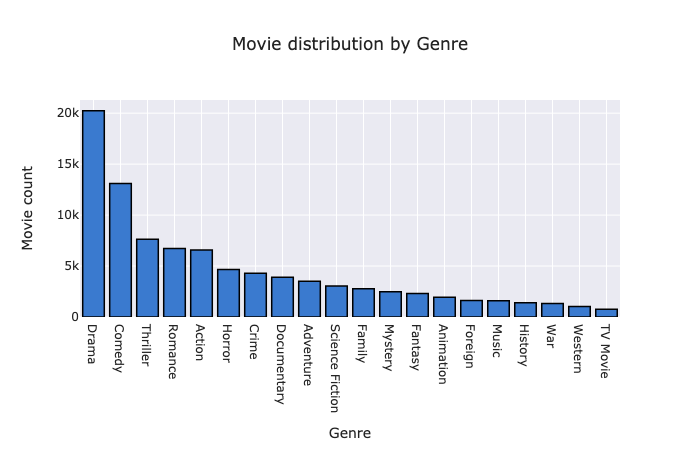

In [23]:
# Get data:
genre_count= genres_df['genre'].value_counts().reset_index()

# Create trace
trace = go.Bar(x = genre_count['index'], 
               y = genre_count['genre'], 
               marker = dict(color = 'rgb(58, 122, 207)', 
                             line=dict(color='rgb(0,0,0)',width=1.5)))

layout = go.Layout(template= "seaborn",title = 'Movie distribution by Genre' , xaxis = dict(title = 'Genre'), yaxis = dict(title = 'Movie count'))

fig = go.Figure(data = [trace], layout = layout)

# fig.show()
fig.show("png")

In [24]:
# Popularity based recommender by different genres:
def recommended_movies(genre, percentile=0.85):
    df = genres_df[genres_df['genre'] == genre] 
    C = df['vote_average'].mean() # Calculate mean vote accross all movies
    m = df['vote_count'].quantile(percentile) # Calculate mininum vote required using 85 percentile
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['original_title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int') # convert vote_count to intigers
    qualified['vote_average'] = qualified['vote_average'].astype('int') # convert vote_average to intigers
    
    qualified['weighted_rating'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('weighted_rating', ascending=False).head(250)
    
    return qualified

In [25]:
# Recommend top 15 adventure monvies:
recommended_movies('Adventure').head(10)

original_title  year  vote_count  vote_average popularity  weighted_rating
15516                                          Inception  2010       14075             8     29.108            7.921
22859                                       Interstellar  2014       11187             8     32.213            7.902
4866   The Lord of the Rings: The Fellowship of the Ring  2001        8892             8     32.071            7.877
7013       The Lord of the Rings: The Return of the King  2003        8226             8     29.324            7.868
5826               The Lord of the Rings: The Two Towers  2002        7641             8     29.424            7.859
255                                            Star Wars  1977        6778             8     42.150            7.842
1225                                  Back to the Future  1985        6239             8     25.779            7.829
1154                             The Empire Strikes Back  1980        5998             8     19.471            7.823
5487                                            千と千尋の神隠し  2001        3968             8     41.049            7.742
9718                                             ハウルの動く城  2004        2049             8     16.136            7.548

### 2. Content based recommender with Cosine similarity

The recommender we built in the previous section suffers some some limitations. For one, it gives the same recommendation to everyone, regardless of the user's personal taste. In this section, we'll build a content-based recommendation system using natural language processing and cosine similarity.

We'll use natural language processing to clean and process text data(movie overview, director, cast, genres and production company). Based on the text content of each movies, we'll use cosine similarity to determine which movies are similar in terms of their content.

So what's cosine similarity? It is essentially a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. Cosine similarity is advantageous because it can determine how similar the documents are irrespective of their sizes.

Let's go ahead and create our second recommendation system.

In [26]:
# Import Rake - short for Rapid Automatic Keyword Extraction algorithm, is a domain independent 
# keyword extraction algorithm which tries to determine key phrases in a body of text by analyzing 
# the frequency of word appearance and its co-occurance with other words in the text.
from rake_nltk import Rake 

In [27]:
# Create a new dataframe with only the needed features for this recommender:
new_df = df[['original_title', 'overview', 'director', 'cast', 'genres', 'production_companies']]

# Drop all missing values:
new_df.dropna(inplace=True)

new_df.head()

original_title                                           overview                                           director                                               cast                          genres                               production_companies
0                    Toy Story  Led by Woody, Andy's toys live happily in his ...  John Lasseter, Joss Whedon, Andrew Stanton, Jo...  Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...       Animation, Comedy, Family                            Pixar Animation Studios
1                      Jumanji  When siblings Judy and Peter discover an encha...  Larry J. Franco, Jonathan Hensleigh, James Hor...  Robin Williams, Jonathan Hyde, Kirsten Dunst, ...      Adventure, Fantasy, Family  TriStar Pictures, Teitler Film, Interscope Com...
3            Waiting to Exhale  Cheated on, mistreated and stepped on, the wom...  Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...  Whitney Houston, Angela Bassett, Loretta Devin...          Comedy, Drama, Romance             Twentieth Century Fox Film Corporation
4  Father of the Bride Part II  Just when George Banks has recovered from his ...  Alan Silvestri, Elliot Davis, Nancy Meyers, Na...  Steve Martin, Diane Keaton, Martin Short, Kimb...                          Comedy         Sandollar Productions, Touchstone Pictures
5                         Heat  Obsessive master thief, Neil McCauley leads a ...  Michael Mann, Michael Mann, Art Linson, Michae...  Al Pacino, Robert De Niro, Val Kilmer, Jon Voi...  Action, Crime, Drama, Thriller    Regency Enterprises, Forward Pass, Warner Bros.

In [28]:
# Text processing:
new_df['Key_words'] = ""

for index, row in new_df.iterrows():
    description = row['overview']
    
    r = Rake() # instantiating Rake, by default it uses english stopwords and discards all puntuation characters
    
    r.extract_keywords_from_text(description) # extracting the words by passing the text

    key_words_scores = r.get_word_degrees() # getting the dictionary with key words as keys and their scores as values
    
    row['Key_words'] = list(key_words_scores.keys())# assigning the key words to the new column 

# Dropping the Plot column
new_df.drop(columns = ['overview'], inplace = True)

In [29]:
# Print out the first 5 rows of Key_words features:
new_df['Key_words'].head()

0    [put, aside, differences, birthday, brings, bu...
1    [living, room, evil, monkeys, door, three, fin...
3    [holding, mistreated, bernie, break, better, w...
4    [daughter, nina, grandchild, george, banks, re...
5    [obsessive, master, thief, violence, neil, mcc...
Name: Key_words, dtype: object

In [30]:
# Discarding the commas between the actors' full names and getting only the first three names
new_df['cast'] = new_df['cast'].map(lambda x: x.split(',')[:3])

# Putting the genres in a list of words
new_df['genres'] = new_df['genres'].map(lambda x: x.lower().split(','))

new_df['director'] = new_df['director'].map(lambda x: x.split(' ')[:3])

# Merging together first and last name for each actor and director, so it's considered as one word 
# and there is no mix up between people sharing a first name
for index, row in new_df.iterrows():
    row['cast'] = [x.lower().replace(' ','') for x in row['cast']]
    row['director'] = ' '.join(row['director']).lower()

In [31]:
# Print out the head of new_df
new_df.set_index('original_title', inplace = True)
new_df.head()

director                                            cast                               genres                               production_companies                                          Key_words
original_title                                                                                                                                                                                                                                 
Toy Story                        john lasseter, joss                [tomhanks, timallen, donrickles]        [animation,  comedy,  family]                            Pixar Animation Studios  [put, aside, differences, birthday, brings, bu...
Jumanji                             larry j. franco,     [robinwilliams, jonathanhyde, kirstendunst]       [adventure,  fantasy,  family]  TriStar Pictures, Teitler Film, Interscope Com...  [living, room, evil, monkeys, door, three, fin...
Waiting to Exhale            forest whitaker, ronald  [whitneyhouston, angelabassett, lorettadevine]           [comedy,  drama,  romance]             Twentieth Century Fox Film Corporation  [holding, mistreated, bernie, break, better, w...
Father of the Bride Part II   alan silvestri, elliot         [stevemartin, dianekeaton, martinshort]                             [comedy]         Sandollar Productions, Touchstone Pictures  [daughter, nina, grandchild, george, banks, re...
Heat                           michael mann, michael             [alpacino, robertdeniro, valkilmer]  [action,  crime,  drama,  thriller]    Regency Enterprises, Forward Pass, Warner Bros.  [obsessive, master, thief, violence, neil, mcc...

In [32]:
# Create bag of words:
new_df['bag_of_words'] = ''
columns = new_df.columns
for index, row in new_df.iterrows():
    words = ''
    for col in columns:
        if col != 'director':
            words = words + ' '.join(row[col])+ ' '
        else:
            words = words + row[col]+ ' '
    row['bag_of_words'] = words

# Drop all features but for bag_of_words:
new_df.drop(columns = [col for col in new_df.columns if col!= 'bag_of_words'], inplace = True)

In [33]:
new_df.head()

bag_of_words
original_title                                                                
Toy Story                    john lasseter, joss tomhanks timallen donrickl...
Jumanji                      larry j. franco, robinwilliams jonathanhyde ki...
Waiting to Exhale            forest whitaker, ronald whitneyhouston angelab...
Father of the Bride Part II  alan silvestri, elliot stevemartin dianekeaton...
Heat                         michael mann, michael alpacino robertdeniro va...

In [34]:
# Instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(new_df['bag_of_words'])

# Creating a Series for the movie titles so they are associated to an ordered numerical
# list that we'll use later to match the indexes
indices = pd.Series(new_df.index)

In [35]:
# Generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)
cosine_sim

array([[1.        , 0.05083286, 0.02777778, ..., 0.02431083, 0.        ,
        0.02777778],
       [0.05083286, 1.        , 0.02541643, ..., 0.0222442 , 0.        ,
        0.        ],
       [0.02777778, 0.02541643, 1.        , ..., 0.0729325 , 0.0404226 ,
        0.02777778],
       ...,
       [0.02431083, 0.0222442 , 0.0729325 , ..., 1.        , 0.01768873,
        0.02431083],
       [0.        , 0.        , 0.0404226 , ..., 0.01768873, 1.        ,
        0.        ],
       [0.02777778, 0.        , 0.02777778, ..., 0.02431083, 0.        ,
        1.        ]])

In [36]:
# Create recommendations function:
def recommendations(Title, cosine_sim = cosine_sim):
    recommended_movies = []
    
    idx = indices[indices == Title].index[0] # getting the index of the movie that matches the title

    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False) # creating a series with the similarity scores 

    top_10_indexes = list(score_series.iloc[1:11].index)# getting the indexes of the 10 most similar movies
    
    for i in top_10_indexes:
        recommended_movies.append(list(new_df.index)[i]) # populating the list with the titles of the best 15 matching movies
        
    return recommended_movies

In [37]:
# Try recommendation for Toy Story:
recommendations('Toy Story')

['Toy Story 2',
 'Toy Story 3',
 'Free Birds',
 'Bolt',
 'Cars 2',
 'The Princess and the Frog',
 'The Wild',
 'Garfield: A Tail of Two Kitties',
 'Over the Hedge',
 'Big Hero 6']

###  3. Content based recommender with clustering technique:

Another way of creating a content-based recommendation system is by using clustering algorithm. Imaging trying to cluster different movies content and characteristics into different clusters using machine learning unsupervised clustering technique and recommend users movies based on which cluster their previous watch falls into.

In this section, I'll use k-means to cluster based on movies' characteristics such as year, vote_count, popularity, runtime, genres, etc.

In [38]:
# Create a new dataset with only needed features:
movies = df[['original_title', 'genres', 'original_language', 'year', 
             'vote_count', 'popularity', 'vote_average', 'runtime']]

# Print out the shape of the dataset:
movies.shape

(7414, 8)

In [39]:
# Change 'popularity' from object type to float for consistency:
movies['popularity'] = movies['popularity'].astype('float64')

movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7414 entries, 0 to 45076
Data columns (total 8 columns):
original_title       7414 non-null object
genres               7414 non-null object
original_language    7414 non-null object
year                 7414 non-null int64
vote_count           7414 non-null float64
popularity           7414 non-null float64
vote_average         7414 non-null float64
runtime              7414 non-null float64
dtypes: float64(4), int64(1), object(3)
memory usage: 521.3+ KB


In [40]:
# Make the title of the movie the index of the dataset:
movies.set_index('original_title', inplace = True)

# Only use the first genre for each movie:
movies['genres'] = movies['genres'].map(lambda x: x.split(',')[:1])
movies['genres'] = movies['genres'].apply(list_to_string)

# Encode class using LabelEncoder:
encoder = LabelEncoder()
movies['original_language'] = encoder.fit_transform(movies['original_language'].values).tolist()

movies.head()

genres  original_language  year  vote_count  popularity  vote_average  runtime
original_title                                                                                                
Toy Story                    Animation                 10  1995    5415.000      21.947         7.700   81.000
Jumanji                      Adventure                 10  1995    2413.000      17.016         6.900  104.000
Waiting to Exhale               Comedy                 10  1995      34.000       3.859         6.100  127.000
Father of the Bride Part II     Comedy                 10  1995     173.000       8.388         5.700  106.000
Heat                            Action                 10  1995    1886.000      17.925         7.700  170.000

In [41]:
X = movies.drop('genres', axis=1)
y = movies['genres']

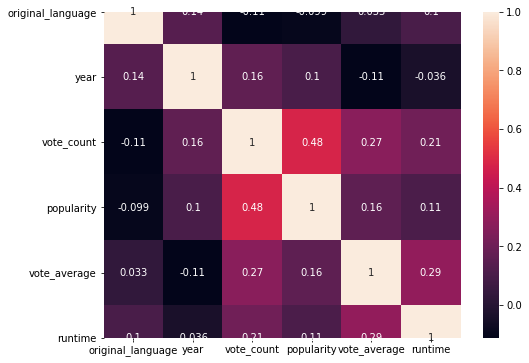

In [42]:
# Create correlation matrix to inspect feature correlation and avoid multicollinearity:
corr_matrix = X.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True)

There's no multicollinearity in our set of features. That good! Popularity and vote count seem to be correlated the most compared to other variables, which makes sense, as the more vote count a movie has, the more likely it is a popular movie.

Now, let's scale your dataset using to prepare for modeling.

In [43]:
# Scale the dataset and put it into a dataframe
X_scaled = StandardScaler().fit_transform(X)
X_scaled= pd.DataFrame(X_scaled, columns=X.columns)

In [44]:
# This is what our scaled dataset looks like:
X_scaled.head()

original_language   year  vote_count  popularity  vote_average  runtime
0             -0.278 -0.297       4.513       1.130         1.459   -1.244
1             -0.278 -0.297       1.727       0.716         0.669   -0.171
2             -0.278 -0.297      -0.481      -0.387        -0.121    0.902
3             -0.278 -0.297      -0.352      -0.007        -0.516   -0.078
4             -0.278 -0.297       1.238       0.792         1.459    2.909

### Clustering using DBSCAN

In [45]:
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=3, min_samples=5)

# Fit the model
clusters = dbscan_cluster.fit(X_scaled)

In [46]:
# Print out the label for the dataset:
labels = clusters.labels_
labels

array([0, 0, 0, ..., 0, 0, 0])

In [47]:
core_samples = np.zeros_like(labels, dtype=bool)
core_samples[dbscan_cluster.core_sample_indices_]=True

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 1
Estimated number of noise points: 17
Silhouette Coefficient: 0.822


In [48]:
X_scaled = X_scaled.to_numpy()

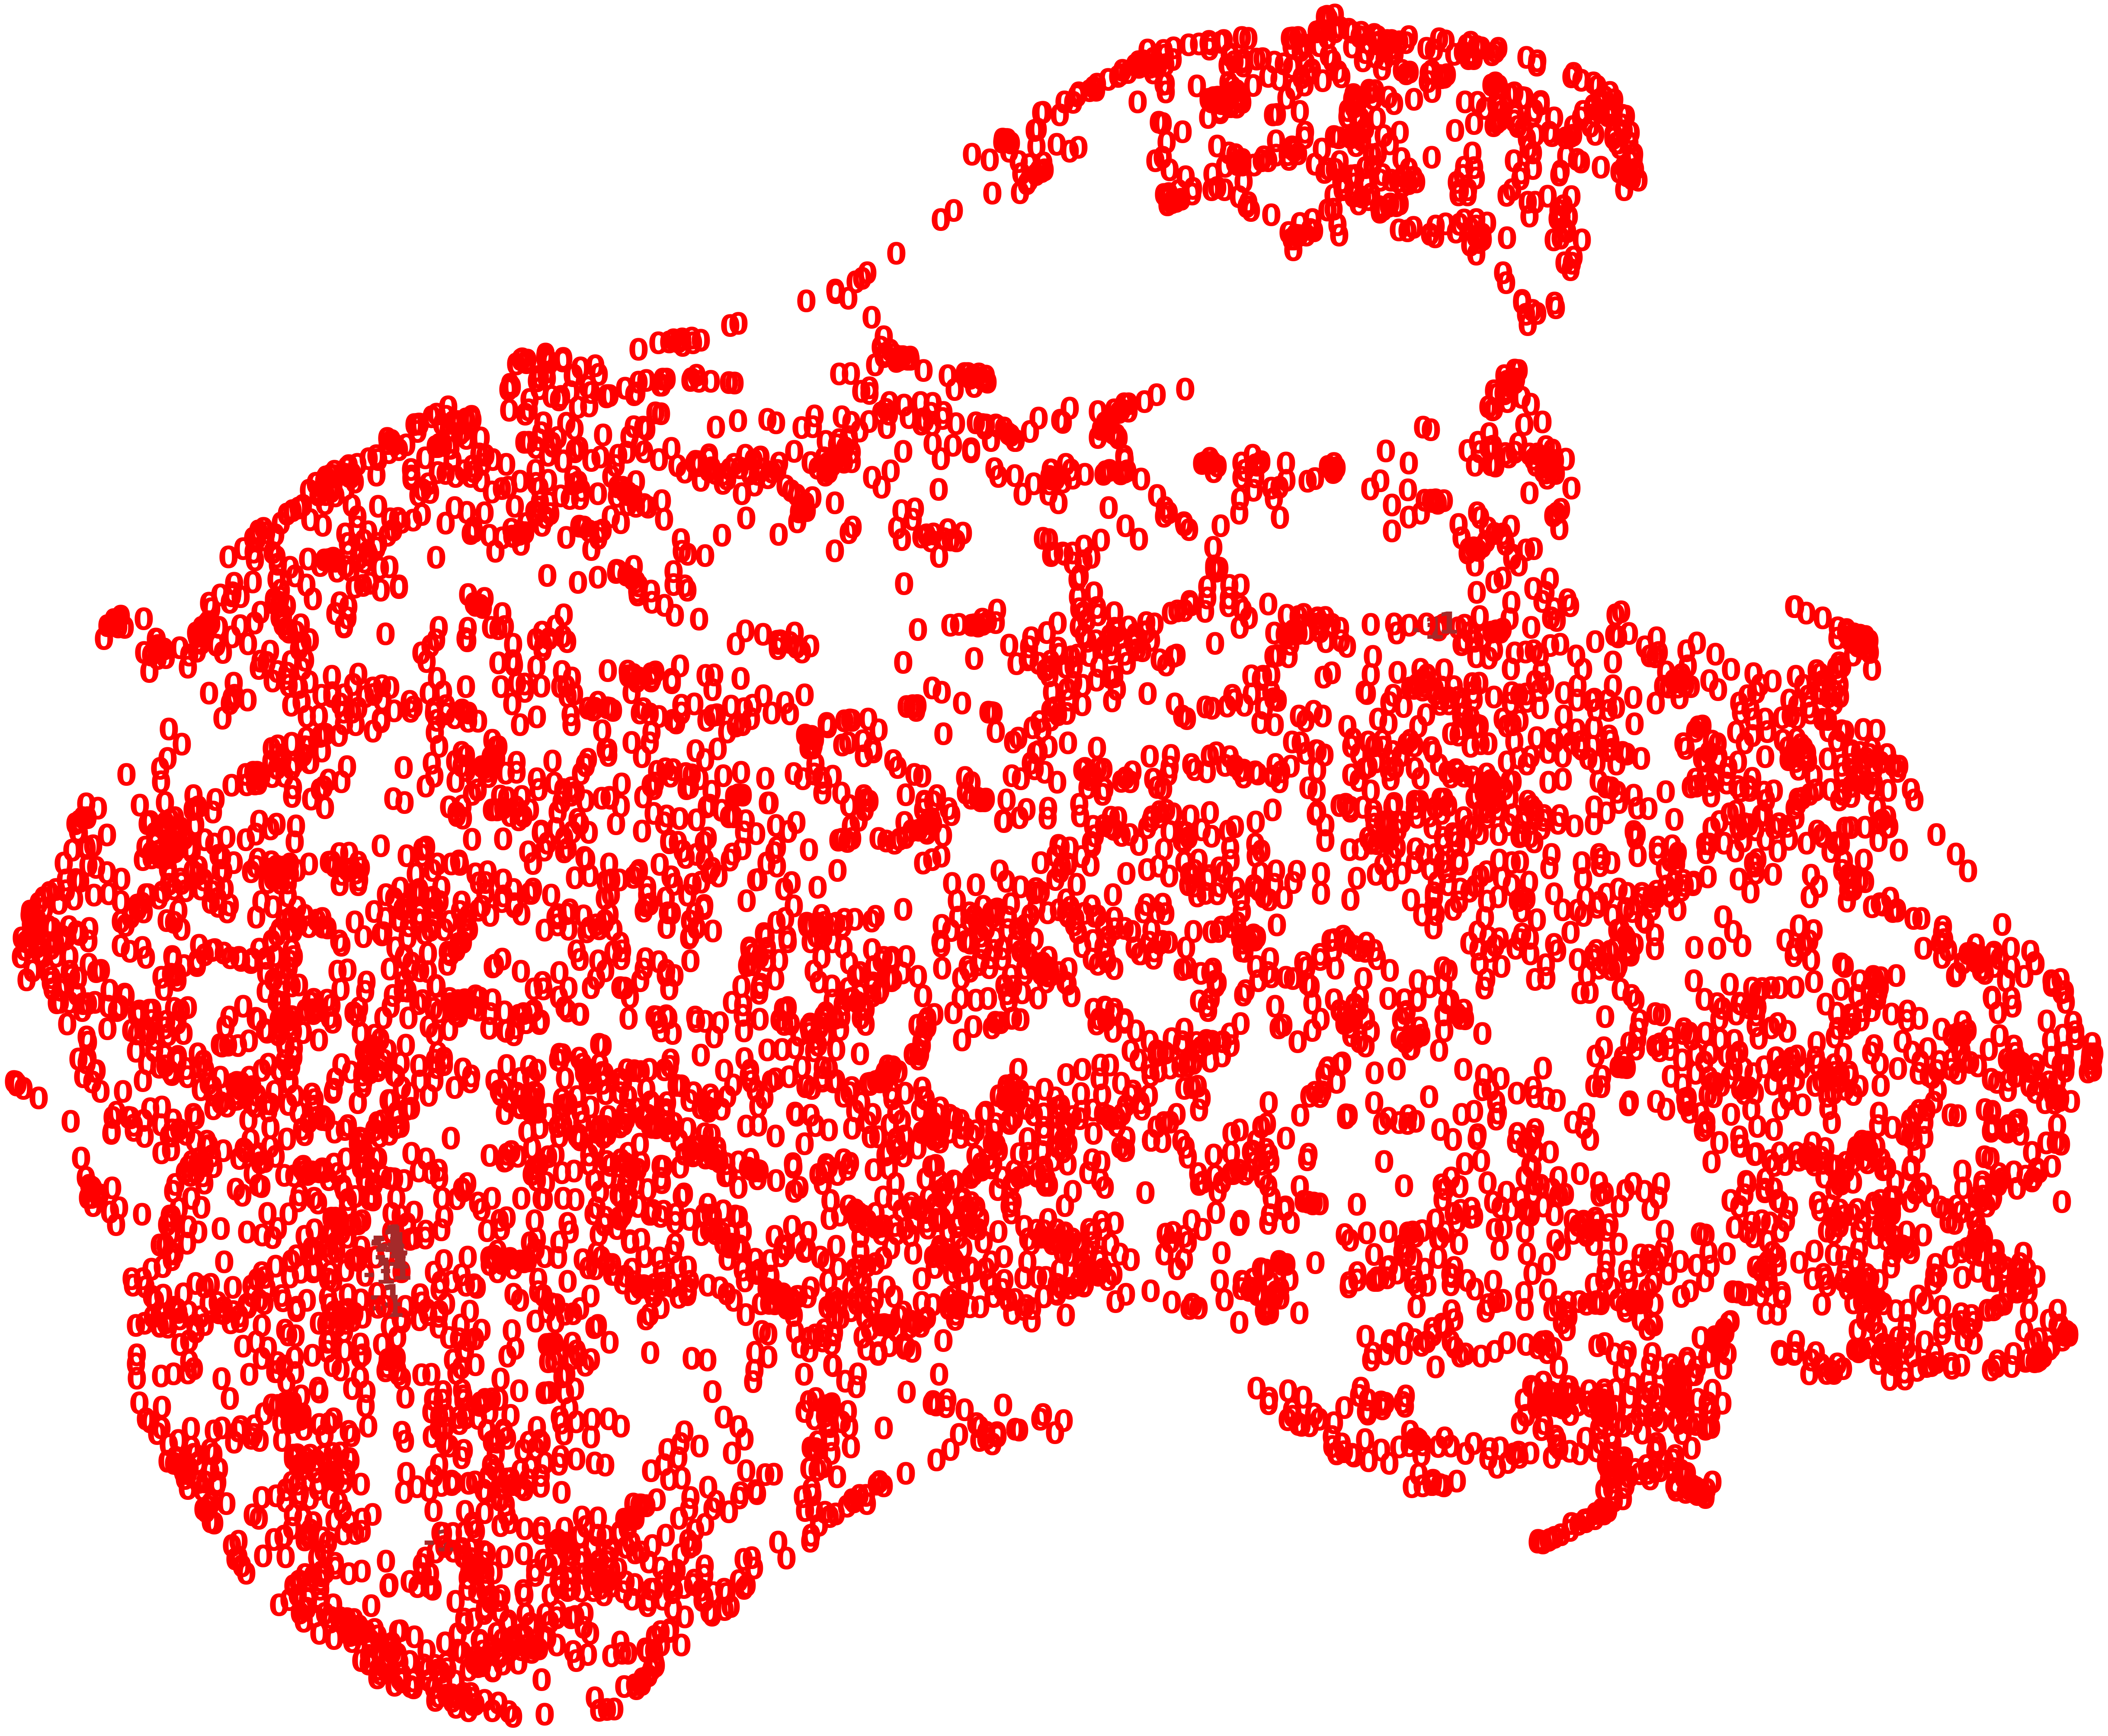

In [49]:
# Visualize the DBSCAN cluster:b
y_pred = dbscan_cluster.fit_predict(X_scaled)

pca = PCA(n_components=2).fit_transform(X_scaled)

umap_results = umap.UMAP(n_neighbors=12,
                      min_dist=0.2,
                      metric='correlation').fit_transform(X_scaled)

colours = ["r","b","g","c","m","y","k","burlywood","chartreuse",'brown']
for i in range(umap_results.shape[0]):
    plt.text(umap_results[i, 0], umap_results[i, 1], y_pred[i],
             color=colours[int(y_pred[i])],
             fontdict={'weight': 'bold', 'size': 70}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

Using DBSCAN clustering technique, we has quite a high silhouette score of 0.822. However, the number of cluster the algorithm gave us is only 1, which is not a desirable outcome as we want to have different clusters in order to recommend similar movies. 

Let's try KMeans clustering technique to see if we'll have a better result.

In [50]:
# Creating k-means algorithm and check for the best k:
Sum_of_squared_distances = []

K = range(1,21)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=123)
    kmeans = kmeans.fit(X_scaled)
    Sum_of_squared_distances.append(kmeans.inertia_)

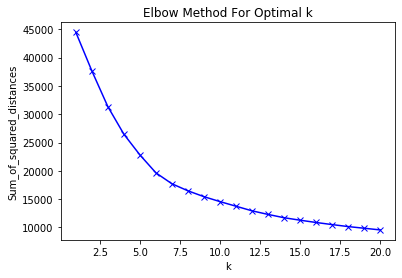

In [51]:
# Plot sum of squared distance plot to find the best k:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

It looks like k=6 is where the elbow is! Let's try clustering using k-means with 6 clusters.

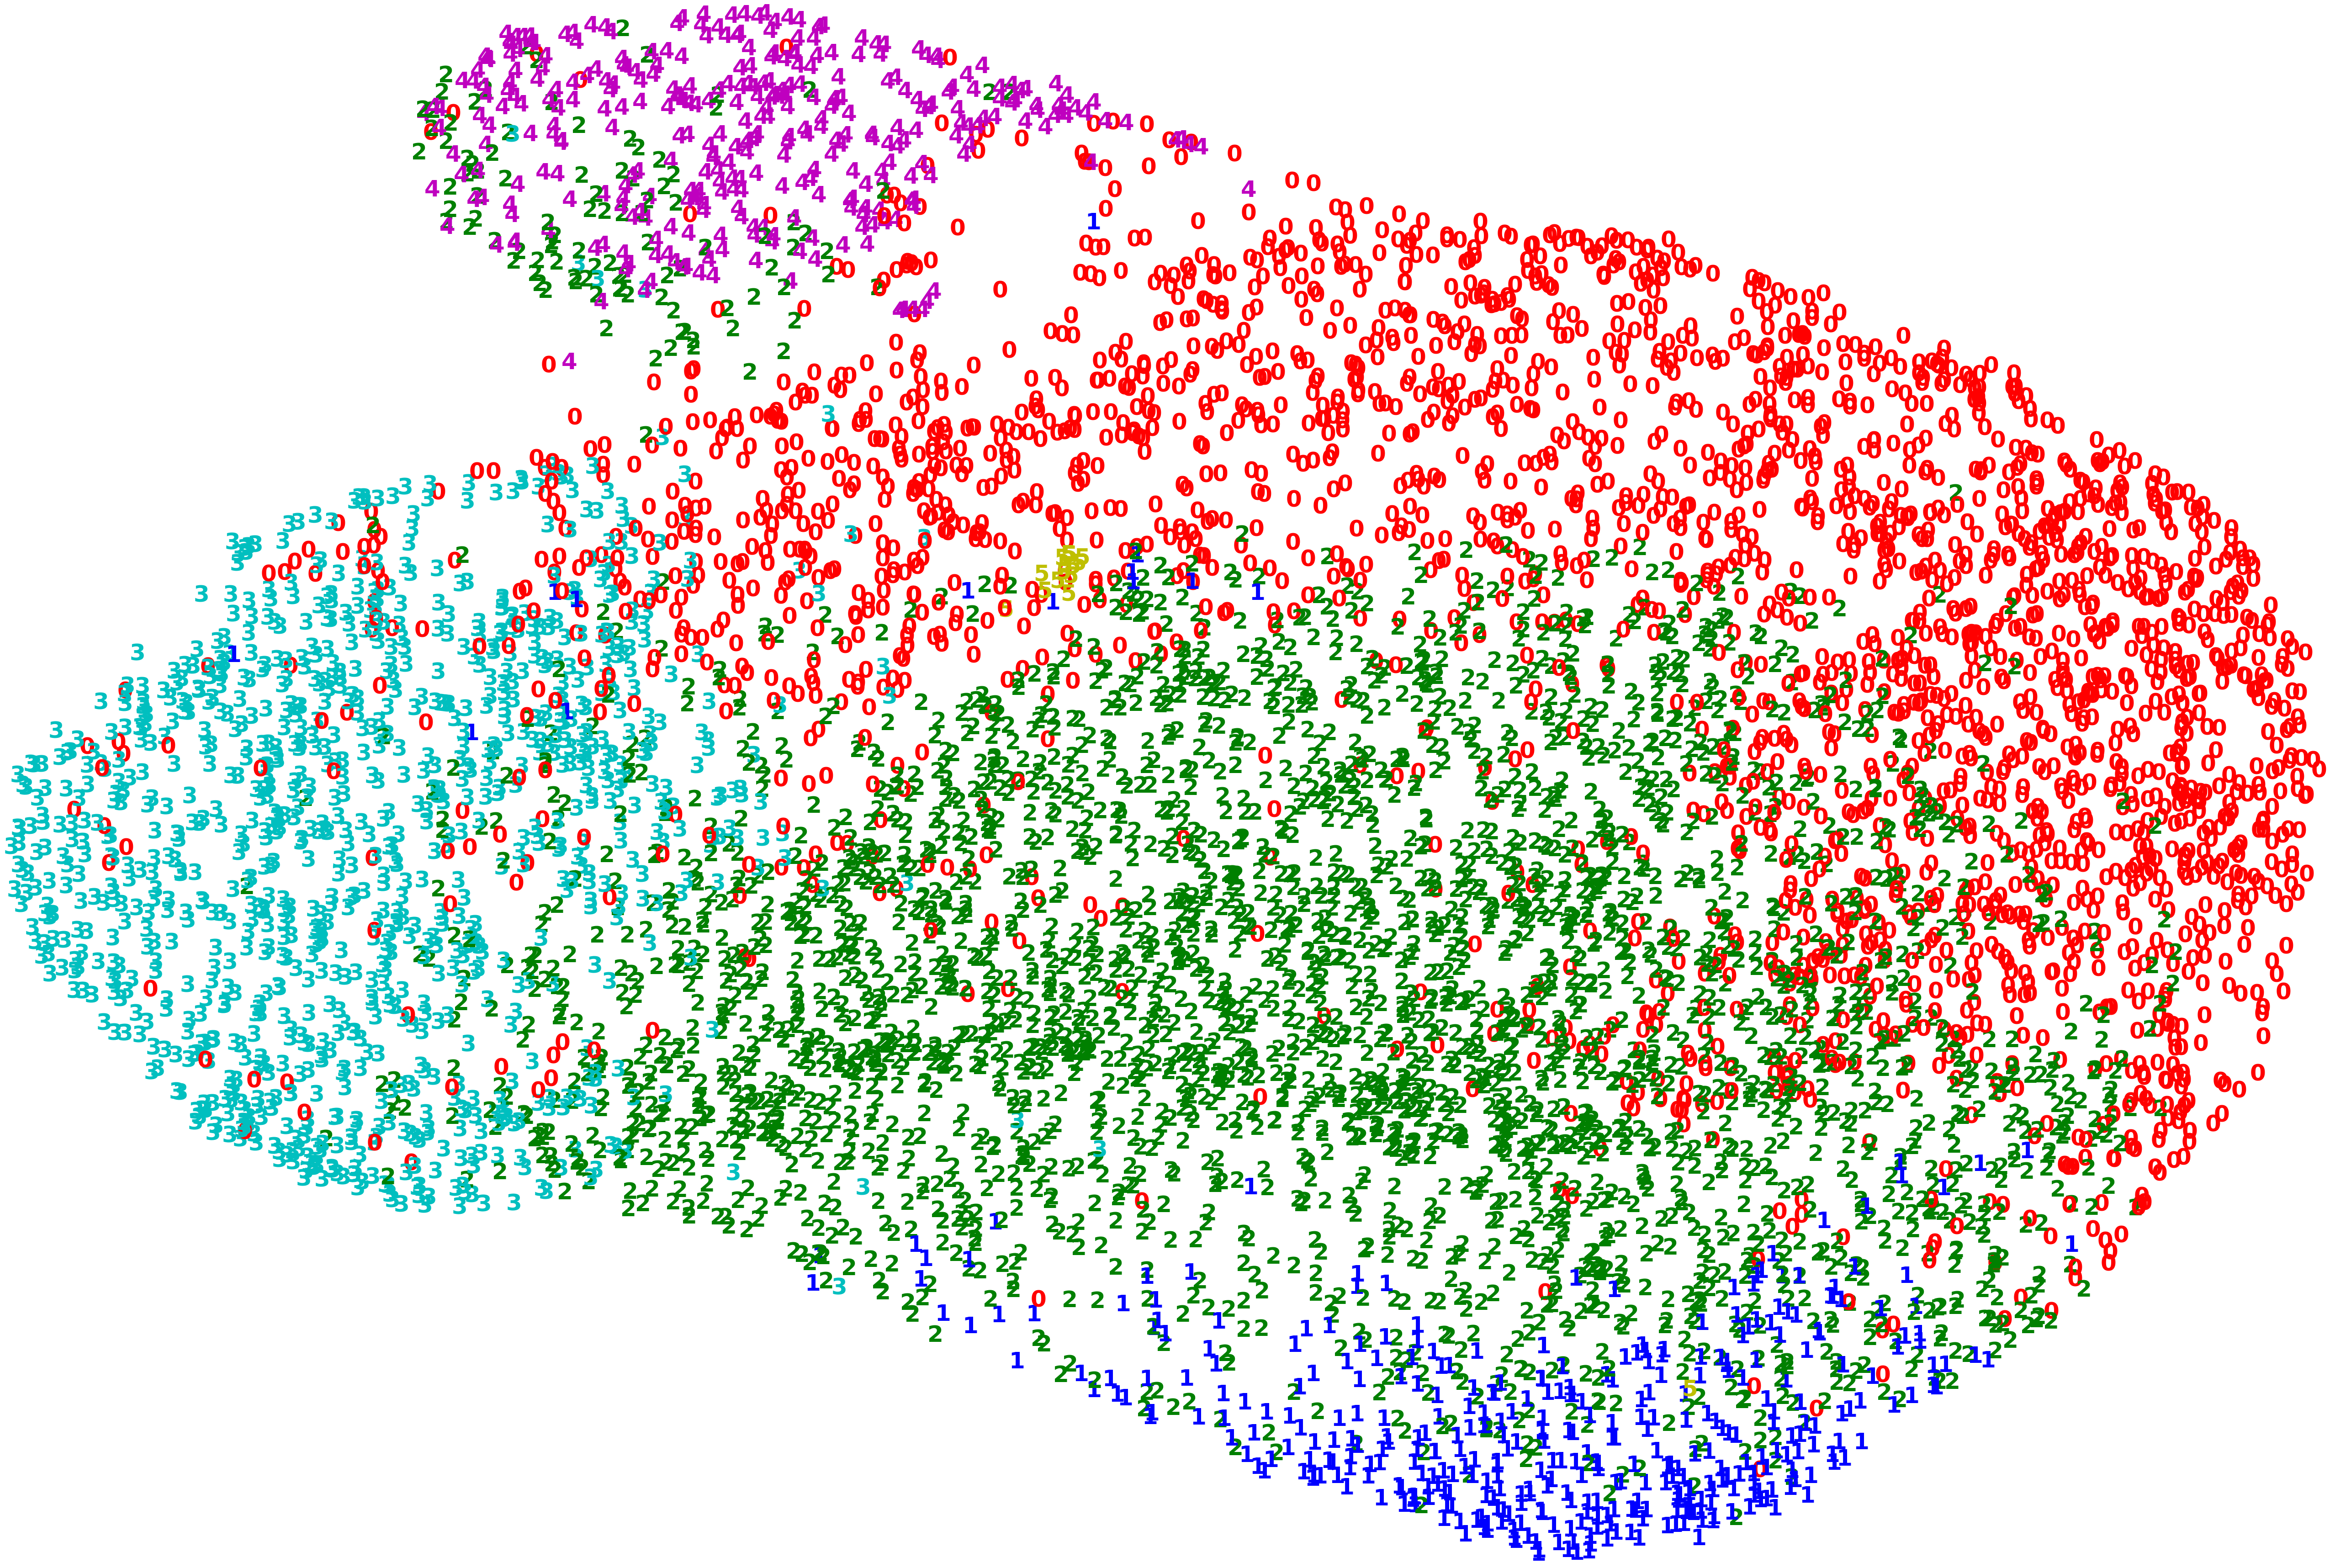

In [52]:
# Defining the k-means
kmeans_cluster = KMeans(n_clusters=6, random_state=123)

# Fit model
kmeans_cluster.fit(X_scaled)
y_pred = kmeans_cluster.predict(X_scaled)

umap_results = umap.UMAP(n_neighbors=100, 
                         min_dist=0.5, 
                         metric='correlation').fit_transform(X_scaled)

colours = ["r","b","g","c","m","y","k","r","burlywood","chartreuse"]
for i in range(umap_results.shape[0]):
    plt.text(umap_results[i, 0], umap_results[i, 1], y_pred[i],
             color=colours[int(y_pred[i])],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [53]:
# Apply k-means with k=6 and calculate silhouette score:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X_scaled)
print("Silhouette score using kmeans is: {}".format(metrics.silhouette_score(X_scaled, labels, metric='euclidean')))

# Create a column for movies dataframe that shows the cluster for each movie:
movies['cluster'] = kmeans.labels_

movies.head()

Silhouette score using kmeans is: 0.8371098809862315


genres  original_language  year  vote_count  popularity  vote_average  runtime  cluster
original_title                                                                                                         
Toy Story                    Animation                 10  1995    5415.000      21.947         7.700   81.000        3
Jumanji                      Adventure                 10  1995    2413.000      17.016         6.900  104.000        3
Waiting to Exhale               Comedy                 10  1995      34.000       3.859         6.100  127.000        4
Father of the Bride Part II     Comedy                 10  1995     173.000       8.388         5.700  106.000        1
Heat                            Action                 10  1995    1886.000      17.925         7.700  170.000        3

Using k-means with k=6, we have quite a high silhouette score. The visualization above doesn't give very distinctive clusters. It looks like cluster 0, 2 and 3 are intertwined quite a bit at the edge of each cluster. Cluster 1 and 4 are distinctive, and they cluster further away from one another. Interestingly, cluster 5(yellow color on the grahp) has a very small number of movies.

Let's now try to use visualization to interpret our clusters. 

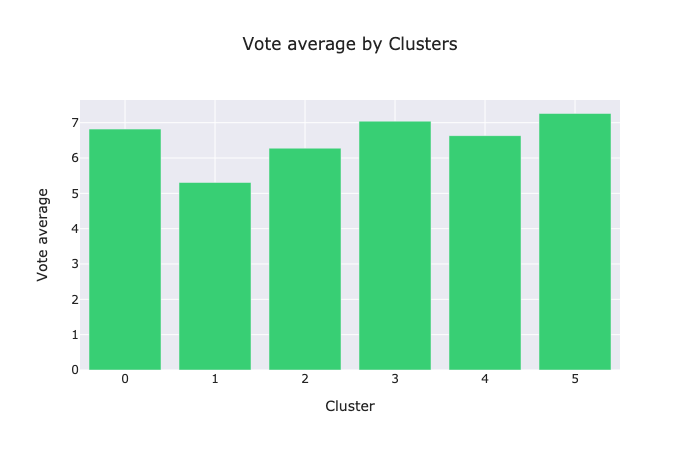

In [54]:
# Get cluster data:
vote_avg_clusters = pd.DataFrame(movies.groupby('cluster')['vote_average'].mean()).reset_index()

# Create trace
trace = go.Bar(x = vote_avg_clusters['cluster'], 
               y = vote_avg_clusters['vote_average'], 
               marker = dict(color = 'rgb(56, 207, 116)' 
                             ))

layout = go.Layout(template= "seaborn",title = 'Vote average by Clusters' , xaxis = dict(title = 'Cluster'), yaxis = dict(title = 'Vote average'))

fig = go.Figure(data = [trace], layout = layout)

# fig.show()
fig.show("png")

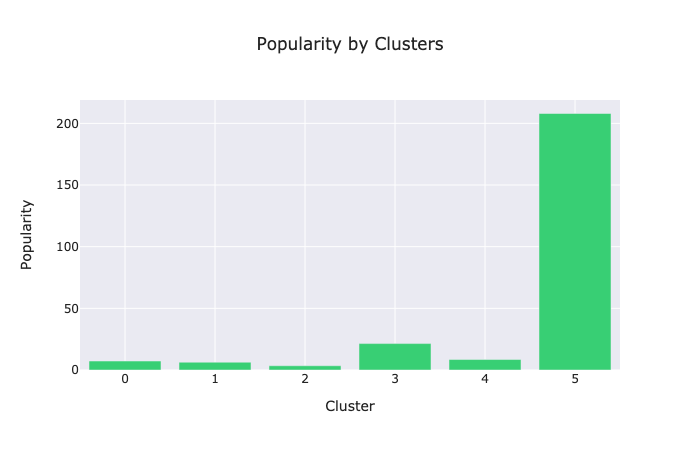

In [55]:
# Get cluster data:
popularity_clusters = movies.groupby('cluster')['popularity'].mean().reset_index()

# Create trace
trace = go.Bar(x = popularity_clusters['cluster'], 
               y = popularity_clusters['popularity'], 
               marker = dict(color = 'rgb(56, 207, 116)' 
                             ))

layout = go.Layout(template= "seaborn",title = 'Popularity by Clusters' , xaxis = dict(title = 'Cluster'), yaxis = dict(title = 'Popularity'))

fig = go.Figure(data = [trace], layout = layout)

# fig.show()
fig.show("png")

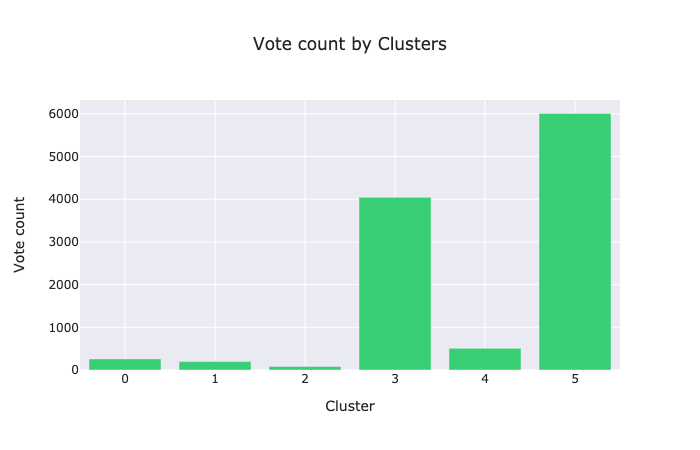

In [56]:
# Get cluster data:
vote_count_clusters = movies.groupby('cluster')['vote_count'].mean().reset_index()

# Create trace
trace = go.Bar(x = vote_count_clusters['cluster'], 
               y = vote_count_clusters['vote_count'], 
               marker = dict(color = 'rgb(56, 207, 116)' 
                             ))

layout = go.Layout(template= "seaborn",title = 'Vote count by Clusters' , xaxis = dict(title = 'Cluster'), yaxis = dict(title = 'Vote count'))

fig = go.Figure(data = [trace], layout = layout)

# fig.show()
fig.show("png")

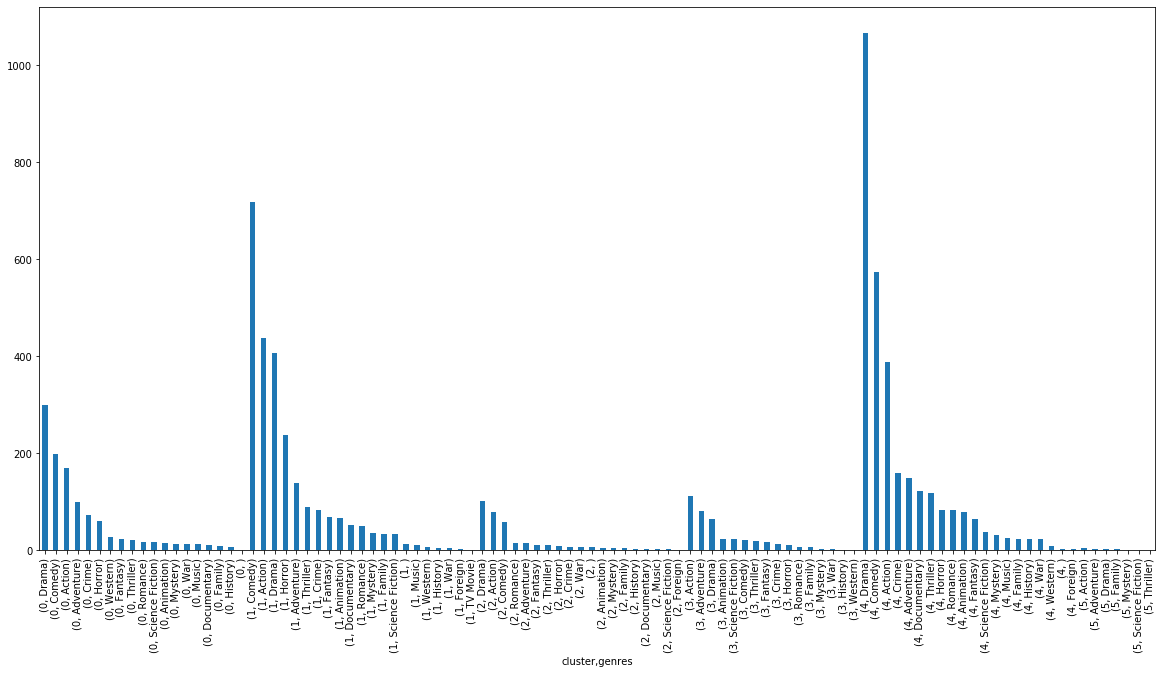

In [57]:
# Clusters by differnt genres:
movies.groupby('cluster')['genres'].value_counts().plot(kind='bar', figsize=[20,10])

In [58]:
# Recommendation for 'Toy Story':
print("'Toy Story' is in cluster number {}".format(movies.loc['Toy Story'].cluster))

'Toy Story' is in cluster number 3


In [74]:
cluster3 = movies[movies['cluster']==3]
recommender = cluster3.sample(n=10)
recommender[['genres', 'runtime', 'year']]

genres  runtime  year
original_title                                                              
Rush                                                    Drama  123.000  2013
Monsters, Inc.                                      Animation   92.000  2001
The Bourne Supremacy                                   Action  108.000  2004
Inception                                              Action  148.000  2010
Quantum of Solace                                   Adventure  106.000  2008
The Matrix Reloaded                                 Adventure  138.000  2003
Zootopia                                            Animation  108.000  2016
Pirates of the Caribbean: The Curse of the Blac...  Adventure  143.000  2003
Donnie Darko                                          Fantasy  113.000  2001
Cinderella                                            Romance  105.000  2015

### 4. Collaborative Filtering with Pearson Correlation

Let's move on to Collaborative filtering recommendation system. This is where user ratings will come into place because recommendations will be made based on other users with 'similar taste'. 

First, let's load the user rating file. We'll use the small dataset to help expedite the algorithm and result.

In [60]:
# Load user ratings dataset:
df3 = pd.read_csv('ratings_small.csv')
df3 = df3.rename(columns={'movieId':'id'}) # rename column 'movieId' to match with df. We'll use this field to connect the 2 datasets later
df3.head()

userId    id  rating   timestamp
0       1    31   2.500  1260759144
1       1  1029   3.000  1260759179
2       1  1061   3.000  1260759182
3       1  1129   2.000  1260759185
4       1  1172   4.000  1260759205

In [61]:
# Merge the user ratings dataset with the master dataset:
user_ratings = pd.merge(df3, df, how='inner', on='id')

In [62]:
user_ratings.head()

userId    id  rating   timestamp genres original_language original_title                                           overview popularity production_companies       revenue  runtime spoken_languages    status                  tagline  vote_average  vote_count  year                                               cast                                           director
0       1  1371   2.500  1260759135  Drama                en      Rocky III  Now the world champion, Rocky Balboa is living...     11.673       United Artists 270000000.000   99.000          English  Released  The greatest challenge.         6.600     894.000  1982  Sylvester Stallone, Talia Shire, Burt Young, C...  Sylvester Stallone, Sylvester Stallone, Robert...
1       4  1371   4.000   949810302  Drama                en      Rocky III  Now the world champion, Rocky Balboa is living...     11.673       United Artists 270000000.000   99.000          English  Released  The greatest challenge.         6.600     894.000  1982  Sylvester Stallone, Talia Shire, Burt Young, C...  Sylvester Stallone, Sylvester Stallone, Robert...
2       7  1371   3.000   851869160  Drama                en      Rocky III  Now the world champion, Rocky Balboa is living...     11.673       United Artists 270000000.000   99.000          English  Released  The greatest challenge.         6.600     894.000  1982  Sylvester Stallone, Talia Shire, Burt Young, C...  Sylvester Stallone, Sylvester Stallone, Robert...
3      19  1371   4.000   855193404  Drama                en      Rocky III  Now the world champion, Rocky Balboa is living...     11.673       United Artists 270000000.000   99.000          English  Released  The greatest challenge.         6.600     894.000  1982  Sylvester Stallone, Talia Shire, Burt Young, C...  Sylvester Stallone, Sylvester Stallone, Robert...
4      21  1371   3.000   853852263  Drama                en      Rocky III  Now the world champion, Rocky Balboa is living...     11.673       United Artists 270000000.000   99.000          English  Released  The greatest challenge.         6.600     894.000  1982  Sylvester Stallone, Talia Shire, Burt Young, C...  Sylvester Stallone, Sylvester Stallone, Robert...

#### What's the distribution of user ratings?

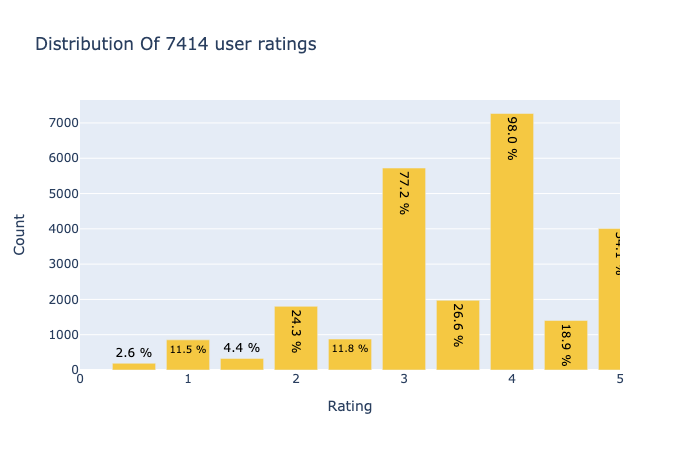

In [63]:
# Get data
data = user_ratings['rating'].value_counts().sort_index(ascending=False)

# Create trace
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               marker = dict(color = '#f5c842'))

# Create layout
layout = dict(title = 'Distribution Of {} user ratings'.format(df.shape[0]),
              xaxis= dict(title = 'Rating', range=[0, 5]),
              yaxis = dict(title = 'Count')
             )

# Create plot
fig = go.Figure(data=[trace], layout=layout)

# iplot(fig)
fig.show("png")

In [64]:
# Only select the features that we'll use in our analysis:
user_ratings = user_ratings[['id', 'original_title', 'userId', 'rating']]
user_ratings.head()

id original_title  userId  rating
0  1371      Rocky III       1   2.500
1  1371      Rocky III       4   4.000
2  1371      Rocky III       7   3.000
3  1371      Rocky III      19   4.000
4  1371      Rocky III      21   3.000

In [65]:
# Pivot user_ratings dataframe:
userRatings = user_ratings.pivot_table(index=['userId'],columns=['original_title'],values='rating')
userRatings.shape

(669, 1197)

In [66]:
# Drop movies which have less than 10 users who rated it and fill NA with 0:
userRatings = userRatings.dropna(thresh=10, axis=1).fillna(0)

# Print out the first 5 rows of user_ratings
userRatings.head()

original_title  10 Items or Less  2 Days in Paris  20,000 Leagues Under the Sea  2001: A Space Odyssey  25th Hour  28 Days Later  28 Weeks Later   300  4 luni, 3 săptămîni și 2 zile  42nd Street  48 Hrs.  8 Mile  88 Minutes  A Bridge Too Far  A Clockwork Orange  A Kiss Before Dying  A Nightmare on Elm Street  A Perfect Murder  A River Runs Through It  A Shot in the Dark  A Time to Kill  A View to a Kill  Addicted to Love  Alexander  Alien  Aliens vs Predator: Requiem  All the King's Men  Almost Famous  American Beauty  American Graffiti  American History X  American Pie  American Pie 2  American Psycho  An Unfinished Life  Apocalypse Now  Armageddon  Ascenseur pour l'échafaud  Astérix aux Jeux Olympiques  Auf der anderen Seite  Austin Powers in Goldmember  Back to the Future  Back to the Future Part II  Back to the Future Part III  Bad Boys II  Baise-moi  Barry Lyndon  Barton Fink  Basquiat  Batman & Robin  Batman Begins  Batman Returns  Bean  Because I Said So  Beetlejuice  \
userId                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
1                          0.000            0.000                         0.000                  0.000      0.000          0.000           0.000 0.000                          0.000        0.000    0.000   0.000       0.000             0.000               0.000                0.000                      0.000             0.000                    0.000               0.000           0.000             0.000             0.000      0.000  0.000                        0.000               0.000          0.000            0.000              0.000               0.000         4.000           0.000            0.000               0.000           0.000       0.000                      0.000                        0.000                  0.000                        0.000               0.000                       0.000                        0.000        0.000      0.000         0.000        0.000     0.000           0.000          0.000           0.000 0.000              0.000        0.000   
2                          0.000            0.000                         0.000                  3.000      0.000          0.000           0.000 0.000                          0.000        0.000    5.000   0.000       0.000             0.000               3.000                0.000                      3.000             0.000                    0.000               0.000           0.000             0.000             0.000      0.000  0.000                        0.000               0.000          0.000            0.000              0.000               0.000         0.000           0.000            0.000               0.000           0.000       0.000                      0.000                        0.000                  0.000                        0.000               0.000                       3.000                        0.000        0.000      0.000         0.000        0.000     0.000           0.000          3.000           3.000 0.000              0.000        0.000   
3                          0.000

In [67]:
# Build similarity matrix using Pearson Correlation:
item_similarity_df = userRatings.corr(method='pearson')
item_similarity_df.head()

original_title                10 Items or Less  2 Days in Paris  20,000 Leagues Under the Sea  2001: A Space Odyssey  25th Hour  28 Days Later  28 Weeks Later   300  4 luni, 3 săptămîni și 2 zile  42nd Street  48 Hrs.  8 Mile  88 Minutes  A Bridge Too Far  A Clockwork Orange  A Kiss Before Dying  A Nightmare on Elm Street  A Perfect Murder  A River Runs Through It  A Shot in the Dark  A Time to Kill  A View to a Kill  Addicted to Love  Alexander  Alien  Aliens vs Predator: Requiem  All the King's Men  Almost Famous  American Beauty  American Graffiti  American History X  American Pie  American Pie 2  American Psycho  An Unfinished Life  Apocalypse Now  Armageddon  Ascenseur pour l'échafaud  Astérix aux Jeux Olympiques  Auf der anderen Seite  Austin Powers in Goldmember  Back to the Future  Back to the Future Part II  Back to the Future Part III  Bad Boys II  Baise-moi  Barry Lyndon  Barton Fink  Basquiat  Batman & Robin  Batman Begins  Batman Returns   Bean  Because I Said So  \
original_title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
10 Items or Less                         1.000            0.041                        -0.040                  0.024     -0.017          0.006           0.006 0.115                         -0.020        0.066    0.035  -0.019       0.060             0.325              -0.006                0.030                      0.002             0.092                    0.008               0.232           0.046             0.026             0.037      0.010  0.008                        0.039               0.020         -0.005            0.135              0.011              -0.018         0.036           0.103           -0.015               0.245          -0.021      -0.039                      0.101                        0.088                  0.009                        0.010               0.027                       0.024                       -0.017        0.020     -0.003         0.107        0.068     0.116          -0.016          0.065           0.008  0.030             -0.024   
2 Days in Paris                          0.041            1.000                         0.024                  0.026     -0.018          0.080           0.232 0.155                          0.259       -0.017    0.053   0.060       0.046             0.170               0.128                0.033                      0.163             0.130                    0.097               0.087           0.107             0.058             0.136      0.202  0.175                        0.119               0.129          0.091            0.108              0.072               0.019         0.127           0.201            0.092               0.153           0.042       0.094                      0.130                        0.217                  0.217                        0.090               0.041                       0.066                        0.133        0.013      0.093         0.102        0.136     0.078           0.302          0.063           0.057  0.118              0.107   
20,000 Leagues Under the

In [68]:
# Define the function to get recommended movies
def get_movie_recommendations(movie_name, user_rating):
    similarity_score = item_similarity_df[movie_name]*(user_rating) # Define similarity score
    similarity_score = similarity_score.sort_values(ascending=False)
    return similarity_score

In [69]:
# Make recommendation:
movie_list = [('A Perfect Murder',4), ('Back to the Future', 5)]

similar_movies = pd.DataFrame()

for movie, rating in movie_list:
  similar_movies = similar_movies.append(get_movie_recommendations(movie, rating), ignore_index=True)

# Print out 10 movie recommendations for someone who 
# rated '24 Hour Party People' 4 and rated 'A Tale of Two Cities' 5:
similar_movies.sum().sort_values(ascending=False)[2:].head(10)

Spanglish                      2.502
Payback                        2.430
Cold Mountain                  2.397
Cinderella Man                 2.313
Deconstructing Harry           2.120
The Breakfast Club             2.081
Notting Hill                   2.038
Le scaphandre et le papillon   2.017
Crank                          1.994
Being John Malkovich           1.984
dtype: float64

### 5. Collaborative Filtering using KNN

We can use the same process above to create another collaborative filtering recommender. However, instead of using Pearson Correlation, this time, we'll use K-nearest neighbor to find the similar users and recommend movies.

In [70]:
# Create a new dataframe by pivoting user_ratings dataframe:
userRatings = user_ratings.pivot_table(index=['original_title'],columns=['userId'],values='rating').fillna(0)
userRatings.head()

userId                       1     2     3     4     5     6     7     8     9     10    11    12    13    14    15    16    17    18    19    20    21    22    23    24    25    26    27    28    29    30    31    32    33    34    35    36    37    38    39    40    41    42    43    44    45    46    47    48    49    50    51    52    53    54    55    56    57    58    59    60    61    62    63    64    65    66    67    68    69    70    71    72    73    74    75    76    77    78    79    80    81    82    83    84    85    86    87    88    89    90    91    92    93    94    95    96    97    98    99    100   101   102   103   104   105   106   107   108   109   110   111   112   113   114   115   116   117   118   119   120   121   122   123   124   125   126   127   128   129   130   131   132   133   134   135   136   137   138   139   140   141   142   143   144   145   146   147   148   149   150   151   152   153   154   155   156   157   158   159   160   161  \
original_title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
10 Items or Less           0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 3.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 4.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 4.000 4.500 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   
10 Things I Hate About You 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 3.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 4.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 3.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   
10,000 BC       

In [71]:
from scipy.sparse import csr_matrix

In [72]:
# Convert dataframe of movie features to scipy sparse matrix
userRatings_parse = csr_matrix(userRatings.values)

# Define our k-nearest neighbor using cosine similarity
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')

# Fit our model to the parsed dataset:
model_knn.fit(userRatings_parse)

# Query the index of movie '25th Hour' to test our model:
query_index = userRatings.index.get_loc('25th Hour')
query_index

14

In [73]:
# Define the indices and distances for our datapoints:
distances, indices = model_knn.kneighbors(userRatings.iloc[query_index,:].values.reshape(1,-1),n_neighbors=10)

# Create recommendations:
for i in range(0,len(distances.flatten())):
    if i==0:
        print("Recommendations for movie: {0}\n".format(userRatings.index[query_index]))
    else:
        print("{0}: {1}, with distance of {2}".format(i,userRatings.index[indices.flatten()[i]],distances.flatten()[i]))

Recommendations for movie: 25th Hour

1: The Brothers Grimm, with distance of 0.6733206961117175
2: Total Recall, with distance of 0.6918309027961742
3: Michael Clayton, with distance of 0.6966858809451074
4: Shrek 2, with distance of 0.7066333247962422
5: The 51st State, with distance of 0.7096183965437489
6: World Trade Center, with distance of 0.7096183965437489
7: L'Auberge espagnole, with distance of 0.7096183965437489
8: I Still Know What You Did Last Summer, with distance of 0.7232326288877023
9: A Few Good Men, with distance of 0.7245198227399272


### IV. Conclusion:

Throughout this notebook, we discovered ways to build recommendation systems using a variety of machine learnings techniques and algorithms. 

We discovered there are 3 main types of recommender: popularity-based filtering, content-based filtering, and collaborative-based filtering , and we tried to implement all of the 3 techniques to our movies dataset.

We first built a popularity-based recommender using movies weighted ratings, which is the most simple method and easy to implement. This method calculate the score for each movie based on a weighted ratings, therefore, litmits the recommendation system to only using ratings as the main driver.

The second recommender we created was content-based recommender using cosine similarity. Cosine similarity calculate the distance of each movie vector on a higher dimensional space. If the two vectors are identical, the angle between them will be 0° and the cosine will be 1. If the two vectors are orthogonal, with an angle of 90°, the cosine will be 0. When we query the similar movies, the algorithm return movies that were most similar to the query movie, ordered from the highest similarity score (cosine) to the lowest. Pretty handy! 

We also created another content-based recommender using unsupervised learning technique that involves clustering movies into different clusters. DBSCAN and KMeans were both used, and there results were compared. Although DBSCAN gave us a high silhouette score, it only detect 1 cluster, which is not what we were looking for. Using KMeans, we were able to detect 6 different clusters of movies to recommend. These clusters, however, were not very distinctive, and my guess is because different movies can fall into the same genres.

The third methods of generating movie recommendation system we tried was collaborative filtering. This is the only technique that takes individual rating into consideration. We built an engine that recommend movies based on other viewers with 'similar taste'. We used Pearson correlation and K-nearest neighbor algorithm to create the recommender engine.

Each technique and algorithm we used has its advantages and disadvantages. Depending on the goal of the decision maker, we want to use different engine to recommend movies. However, the best way would probably be to use a combination of the above algorithm in real life. For example, Netflix, Hulu, Disney+ and many other online movie providers have a few different recommendation sections in their sites. Whether it is "Trending now", "Top picks for you" or "Because you watch ABC movie", those different recommender really help provide options to consumers and let them choose based on their preference.

In real life, this type of recommendation system can be applied in a variety of situations and services. Some of the examples are: book recommendation system on an online book store, product recommendation on a e-commerce, song recommendation, restaurant recommendation, and so on.